In [2]:
def stepwise_selection(X, y,
					   initial_list=[],
					   threshold_in=0.05,
					   threshold_out=0.10,
					   verbose=True):
	"""
	Perform a stepwise feature selection based on p-values from statsmodels OLS.

	Parameters:
	- X : pd.DataFrame
		Candidate feature set (independent variables).
	- y : pd.Series or np.array
		Target variable (dependent variable).
	- initial_list : list
		Initial list of features to start the selection process.
	- threshold_in : float
		p-value threshold for adding a feature (smaller = more strict).
	- threshold_out : float
		p-value threshold for removing a feature (larger = more lenient).
	- verbose : bool
		Whether to print progress during feature selection.

	Returns:
	- included : list
		The final list of selected features.
	"""

	included = list(initial_list)  # Start with an initial list (could be empty)

	while True:
		changed = False  # Flag to track whether any feature was added or removed in the current iteration; If not, the loop will break

		# --- Forward Step ---
		# Try adding each feature not yet included and check p-values
		excluded = list(set(X.columns) - set(included))  # Compute the list of features not yet included in the model; These are the candidates for addition
		new_pval = pd.Series(index=excluded, dtype=float)  # Initialise a Series to store the p-values of each excluded feature if it were to be added to the model
		for new_column in excluded: # Iterate over all excluded features to assess their contribution
			# Fit OLS model with the current included features + this new one
			X_with_const = sm.add_constant(X[included + [new_column]]) # Prepare the design matrix with a constant term (intercept) and the current included features plus the candidate new feature
			model = sm.OLS(y, X_with_const).fit() # Fits an Ordinary Least Squares (OLS) linear regression model to the current design matrix
			new_pval[new_column] = model.pvalues[new_column]  # Extract the p-value of the newly added feature and stores it

		# Add the feature with the lowest p-value if it's below threshold_in
		if not new_pval.empty and new_pval.min() < threshold_in: # Check whether the smallest p-value among the excluded features is statistically significant, i.e., below the inclusion threshold
			best_pval = new_pval.idxmin()  # Feature with the smallest p-value
			included.append(best_pval)
			changed = True
			if verbose:
				print(f'Add {best_pval} with p-value {new_pval.min():.6f}')

		# --- Backward Step ---
		# Now check if any included feature should be removed
		X_with_const = sm.add_constant(X[included])
		model = sm.OLS(y, X_with_const).fit() # Re-fit the model using the current set of included features to re-calculate all p-values
		pvalues = model.pvalues.iloc[1:]  # Get p-values for all features excluding the intercept (which is the first value); These are the features being evaluated for possible removal

		# If any included feature has a p-value above threshold_out, remove the worst one
		if not pvalues.empty and pvalues.max() > threshold_out: # If the worst (largest) p-value among included features exceeds the exclusion threshold, it’s a candidate for removal
			worst_pval = pvalues.idxmax() # Find the feature with the worst (largest) p-value
			included.remove(worst_pval) # Remove this feature from the model
			changed = True
			if verbose:
				print(f'Drop {worst_pval} with p-value {pvalues.max():.6f}')

		# If no feature was added or removed, the process is done
		if not changed:
			break

	# Print final selected features and summary
	if verbose:
		print("\nFinal Selected Variables:")
		print(included)
		final_X_with_const = sm.add_constant(X[included])
		final_model = sm.OLS(y, final_X_with_const).fit()
		print("\nFinal Model Summary:")
		print(final_model.summary())

	return included

In [180]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,MaxAbsScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.model_selection import  GridSearchCV
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [96]:
dir(sklearn.model_selection)

In [ ]:
ocean_data

In [144]:
# 분류 
ocean_data = pd.read_csv('data/rate_ocean_final.csv')

ocean_data.set_index('Date',inplace=True)

# ocean_data=ocean_data[col]

In [5]:
col=['가자미류', '청어', '새우', '대구', '도루묵', '기타어류', '총어획량 ', '금지여부','염분_50m','염분_100m', '염분_200m', '염분_300m', '염분_400m', '염분_500m', '해저수온_100m','해저수온_200m', '해저수온_300m', '해저수온_400m', '해저수온_500m','mean_해수면높이','평균 풍속(m/s)', '평균기압(hPa)', '평균 상대습도(%)', '평균 기온(°C)', '평균 최대 파고(m)','평균 파주기(sec)']

In [103]:
ocean_data

In [8]:
data_col

['가자미류', '청어', '새우', '대구', '도루묵', '기타어류']

In [145]:
data_col = ocean_data.iloc[:,:6].columns.tolist()

In [146]:
for i in data_col:
    ocean_data[i]= ocean_data[i]*0.01

In [106]:
ocean_data

In [168]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_path = r'C:/Windows/Fonts/H2GTRM.TTF' # HY견명조 폰트 경로

# 2. FontProperties 객체 생성
font_prop = fm.FontProperties(fname=font_path).get_name()

# 3. 마이너스 부호 설정 (필요한 경우)
plt.rc('font', family=font_prop)

plt.rc('axes', unicode_minus=False)

In [86]:
X = ocean_data.drop(data_col,axis=1)
y = ocean_data[data_col]
select_col= stepwise_selection(X,y)

ValueError: shapes (727,6) and (727,6) not aligned: 6 (dim 1) != 727 (dim 0)

In [73]:
data_col = ocean_data.iloc[:,:6].columns.tolist()

In [74]:
data_col

['가자미류', '청어', '새우', '대구', '도루묵', '기타어류']

In [117]:
select_col = select_col+['총어획량 ']


In [380]:
X

In [87]:
select_col = stepwise_selection(X, y.loc[:,'도루묵'], verbose=True)

Add 해수유속(N)_50m with p-value 0.000000
Add 클로로필_500m with p-value 0.000000
Add 금지여부 with p-value 0.000000
Add 해저수온_400m with p-value 0.000000
Add 해저수온_100m with p-value 0.000000
Add 클로로필_200m with p-value 0.000007
Add 염분_100m with p-value 0.000001
Add 평균기압(hPa) with p-value 0.000000
Add 클로로필_50m with p-value 0.000000
Add 총어획량  with p-value 0.000001
Add mean_해수면높이 with p-value 0.000992
Add 염분_500m with p-value 0.000483
Add mean_광확산 감쇠 계수 with p-value 0.028921
Add mean_혼합층 깊이 with p-value 0.005734
Add  인산염_50m with p-value 0.010668
Add 염분_200m with p-value 0.016937
Add 용존 산소_300m with p-value 0.004386
Drop 염분_500m with p-value 0.245699
Add 규산염_50m with p-value 0.001201
Add 질산염_100m with p-value 0.004085

Final Selected Variables:
['해수유속(N)_50m', '클로로필_500m', '금지여부', '해저수온_400m', '해저수온_100m', '클로로필_200m', '염분_100m', '평균기압(hPa)', '클로로필_50m', '총어획량 ', 'mean_해수면높이', 'mean_광확산 감쇠 계수', 'mean_혼합층 깊이', ' 인산염_50m', '염분_200m', '용존 산소_300m', '규산염_50m', '질산염_100m']

Final Model Summary:
             

In [14]:
data=ocean_data[data_col]

In [75]:
def create_sequence(data, window_size,target_name):
    y_data= data[target_name].values
    times = data.index
    data = data.values
    X, y = [], []
    time_list = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(y_data[i + window_size])
        time_list.append(times[i + window_size])
    X, y = np.array(X), np.array(y)
    return X,y,time_list

In [147]:
data_col

['가자미류', '청어', '새우', '대구', '도루묵', '기타어류']

In [90]:
total_col=select_col+data_col

In [148]:
ocean_data=ocean_data[data_col]

In [150]:
window_size = 56
X,y,time_list = create_sequence(ocean_data, window_size,data_col)

In [151]:
split_index = int(len(X) * 0.8)
X_train_raw, y_train_raw = X[:split_index], y[:split_index]
X_test_raw, y_test_raw = X[split_index:], y[split_index:]
time_list_train,time_list_test=time_list[:split_index],time_list[split_index:]
feauture_num = X_train_raw.shape[2]

In [181]:
scaler= RobustScaler()
y_scaler= MinMaxScaler()

In [182]:
X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, feauture_num)).reshape(X_train_raw.shape)
y_train =y_scaler.fit_transform(y_train_raw.reshape(-1, y_train_raw.shape[1]))


X_test_scaled = scaler.transform(X_test_raw.reshape(-1, feauture_num)).reshape(X_test_raw.shape)
y_test = y_scaler.transform(y_test_raw.reshape(-1, y_test_raw.shape[1]))

X_train=X_train_scaled
X_train
X_test=X_test_scaled
X_test

array([[[ 0.36245955,  0.70247934,  1.48888889, -0.36363636,
         -0.42679128, -0.23913043],
        [ 0.5987055 ,  0.64738292,  0.57777778, -0.43636364,
         -0.43302181, -0.36956522],
        [ 0.88349515,  0.18181818,  0.46666667, -0.47272727,
         -0.16510903, -0.32608696],
        ...,
        [ 1.27508091, -0.38567493,  1.2       ,  0.47272727,
         -0.33333333,  0.84782609],
        [ 0.39482201, -0.38347107,  1.4       , -0.16363636,
         -0.2305296 ,  6.59130435],
        [ 1.21682848, -0.384573  ,  0.22222222, -0.30909091,
         -0.1588785 ,  1.90434783]],

       [[ 0.5987055 ,  0.64738292,  0.57777778, -0.43636364,
         -0.43302181, -0.36956522],
        [ 0.88349515,  0.18181818,  0.46666667, -0.47272727,
         -0.16510903, -0.32608696],
        [ 0.51779935, -0.33608815,  2.4       , -0.36363636,
          0.49221184, -0.39130435],
        ...,
        [ 0.39482201, -0.38347107,  1.4       , -0.16363636,
         -0.2305296 ,  6.59130435],
  

In [141]:
y_test.shape

In [442]:
xgb = XGBClassifier(random_state=42,)
xgb.fit(X_train_reshape,y_train)
y_pred = xgb.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [438]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reshape,y_train)
y_pred = dt.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [434]:
# RF
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train,y_train)
y_pred=RF.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [ ]:
model_xgb = XGBClassifier(random_state=42)
hyperparams_xgb = {'n_estimators': [100, 200, 300],
				 'learning_rate': [0.01, 0.05, 0.1],
				 'max_depth': [3, 5, 7]}    
model_rf = RandomForestClassifier(random_state=42)
hyperparams_rf = {'n_estimators': [10, 50, 100],
				'max_depth': [None, 10, 20],
				'min_samples_split': [2, 5, 10],
				'min_samples_leaf': [1, 2, 4],
				'bootstrap': [True, False],}

In [ ]:
model_info = GridSearchCV(estimator=model_xgb,
                    param_grid = hyperparams_xgb,
                    cv=5)
model_info.fit(X_train,y_train)
model_n = model_info.best_estimator_
y_pred = model_n.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [ ]:
y_test_raw = y_test_raw.reshape(-1)
y_test_raw.shape

In [143]:
rf_df = pd.DataFrame({'time':time_list_test,'y_test':y_test_raw,'y_pred':y_pred})


In [113]:
plt.plot(rf_df['time'],rf_df['y_test'],label='actual')
plt.plot(rf_df['time'],rf_df['y_pred'],alpha=0.5,label='pred')
plt.legend()
plt.show()

In [ ]:
model_info = GridSearchCV(estimator=model_rf,
                    param_grid = hyperparams_rf,
                    cv=5)
model_info.fit(X_train,y_train)
model_n = model_info.best_estimator_
y_pred = model_n.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [116]:
from tensorflow import keras

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten,Dropout,SimpleRNN,LSTM, MaxPooling1D,AveragePooling1D,GlobalAvgPool1D

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto' )

In [136]:
y_test

In [125]:
X_train_reshape = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_test_reshape = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])

In [126]:
Fnn = Sequential()
Fnn.add(Dense(128,activation='relu',input_dim=(X_train_reshape.shape[1])))
Fnn.add(Dense(64,activation='relu'))
Fnn.add(Dense(32,activation='relu'))
Fnn.add(Dense(y_train.shape[1],activation='softmax'))
Fnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
Fnn.summary()

In [299]:
train_x_cnn.shape

In [440]:
Fnn_history = Fnn.fit(X_train_reshape,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

In [441]:
y_pred = Fnn.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print('-----------FNN-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [129]:
X_train.shape[2]

24

In [136]:
Cnn = Sequential()
Cnn.add(Conv1D(64,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn.add(MaxPooling1D(2))
Cnn.add(Flatten())
Cnn.add(Dense(32,activation = 'relu'))
Cnn.add(Dense(16,activation = 'relu'))
Cnn.add(Dense(y_train.shape[1]))

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
y_train.shape[1]

1

In [175]:
# model=Sequential([
#             Conv1D(64,3, activation='relu', input_shape=(self.window_size,4)),
#             Conv1D(32,3,activation='relu'),
#             Flatten(),
#             Dense(50,activation='relu'),
#             Dense(1)
#         ])
#         model.compile(optimizer='adam',loss='mse')

In [183]:
Lstm = Sequential()
Lstm.add(SimpleRNN(units=64, activation='tanh', return_sequences=False,input_shape=(X_train.shape[1],X_train.shape[2])))

Lstm.add(Dense(units=16))

#출력층
Lstm.add(Dense(y_train.shape[1]))

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [184]:
Lstm.compile(optimizer='adam', loss='mse')
Lstm.summary()
Lstm_history = Lstm.fit(X_train,y_train,epochs=100,validation_split=0.2,callbacks=[early_stopping])

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │         4,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,686 (22.21 KB)

 Trainable params: 5,686 (22.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.3021 - val_loss: 0.1339
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1136 - val_loss: 0.0683
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0607 - val_loss: 0.0486
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0408 - val_loss: 0.0369
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0338 - val_loss: 0.0342
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0294 - val_loss: 0.0303
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0291 - val_loss: 0.0296
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0251 - val_loss: 0.0266
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0219 - val_loss: 0.0271
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0230 - val_loss: 0.0254
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0213 - val_loss: 0.0245
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss:

In [103]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

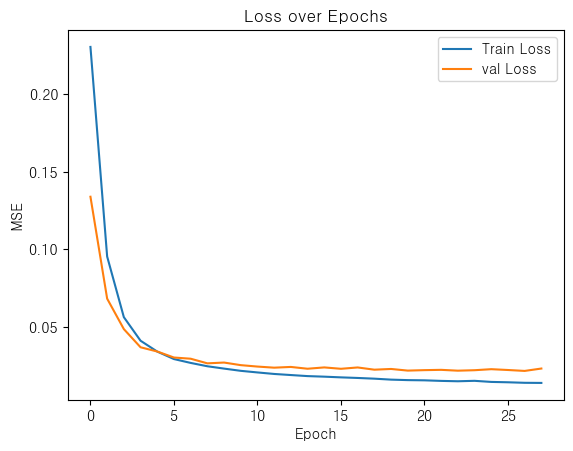

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
MSE: 0.030176951966448023
MAE: 0.1269285705082613


In [185]:

plt.plot(Lstm_history.history['loss'], label='Train Loss')
plt.plot(Lstm_history.history['val_loss'], label='val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

y_pred_scaled = Lstm.predict(X_test)
y_pred= y_scaler.inverse_transform(y_pred_scaled)

mse= mean_squared_error(y_test_raw, y_pred )
mae= mean_absolute_error(y_test_raw, y_pred )
print('MSE:', mse)
print('MAE:', mae)

In [119]:
X_test.shape

(145, 4, 24)

가자미류Mse: 0.09130848037491075 Mae: 0.2655981167847981
청어Mse: 0.027905964397429338 Mae: 0.1306885291672619
새우Mse: 0.008306288669451423 Mae: 0.06829460286667778
대구Mse: 0.016707597710940388 Mae: 0.09421092896320754
도루묵Mse: 0.02667808859822122 Mae: 0.12867735305051728
기타어류Mse: 0.010155292047734958 Mae: 0.07410189221710518


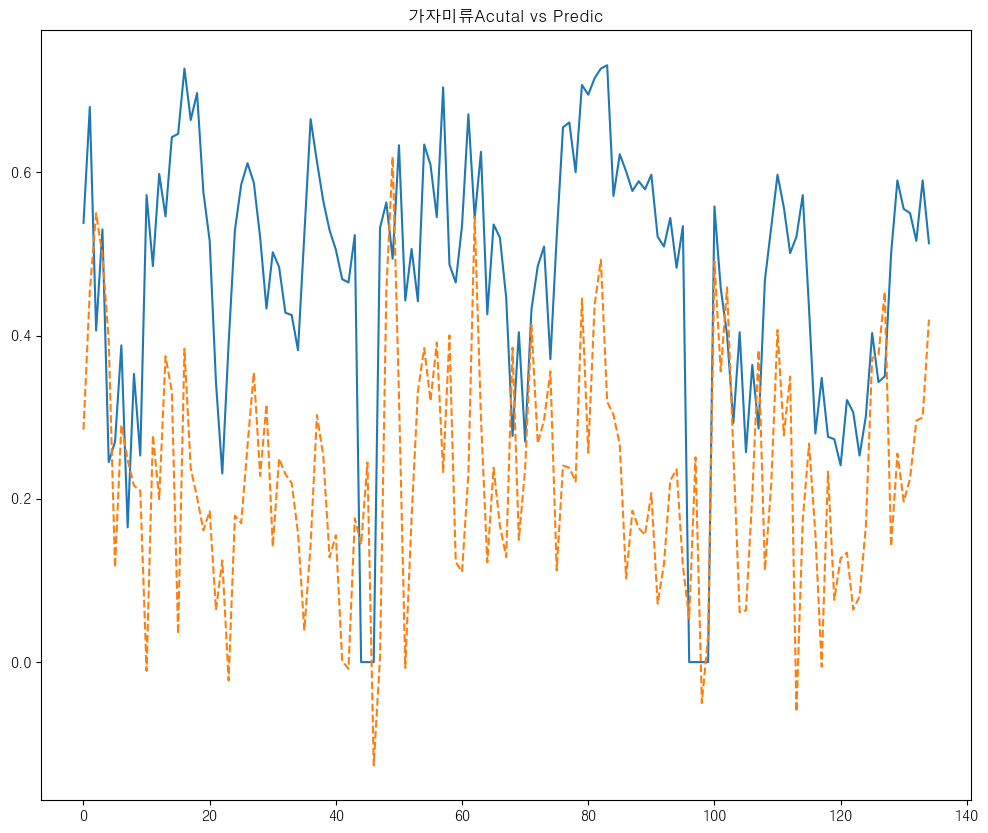

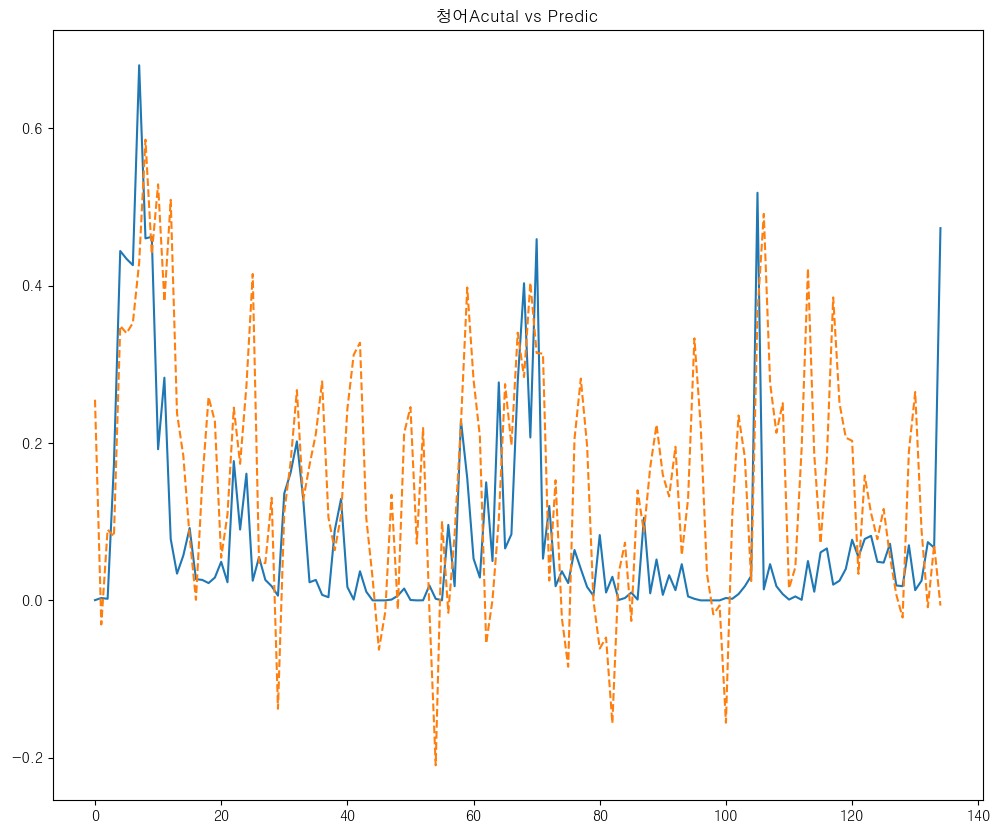

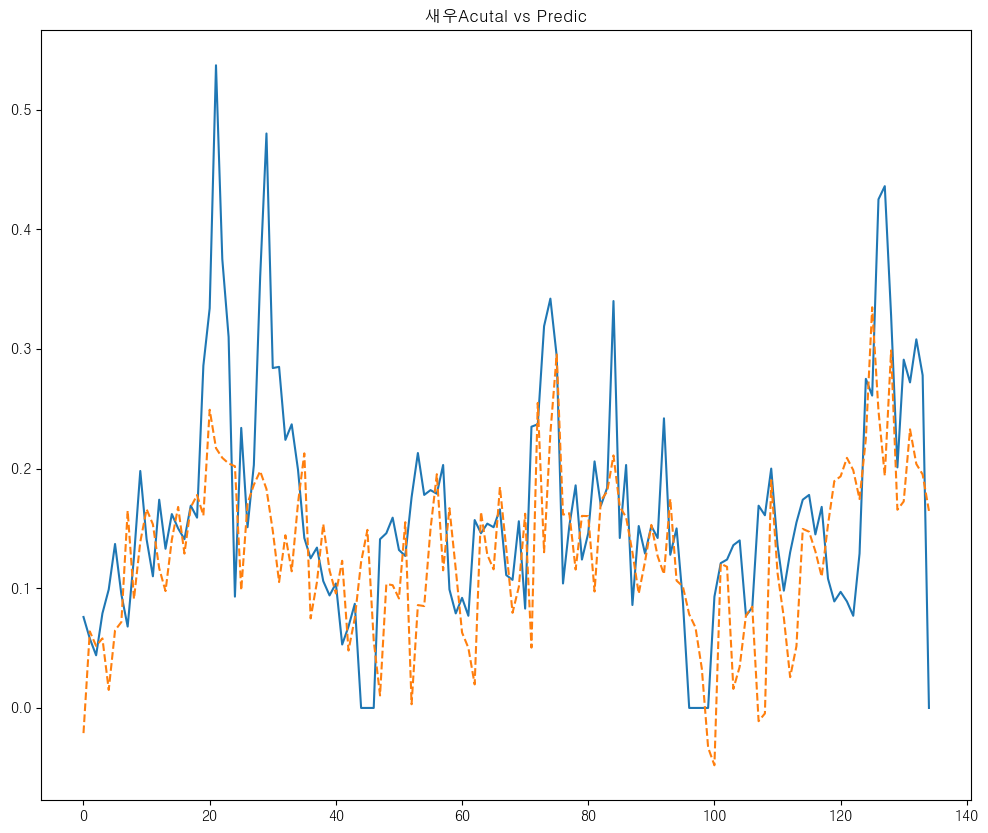

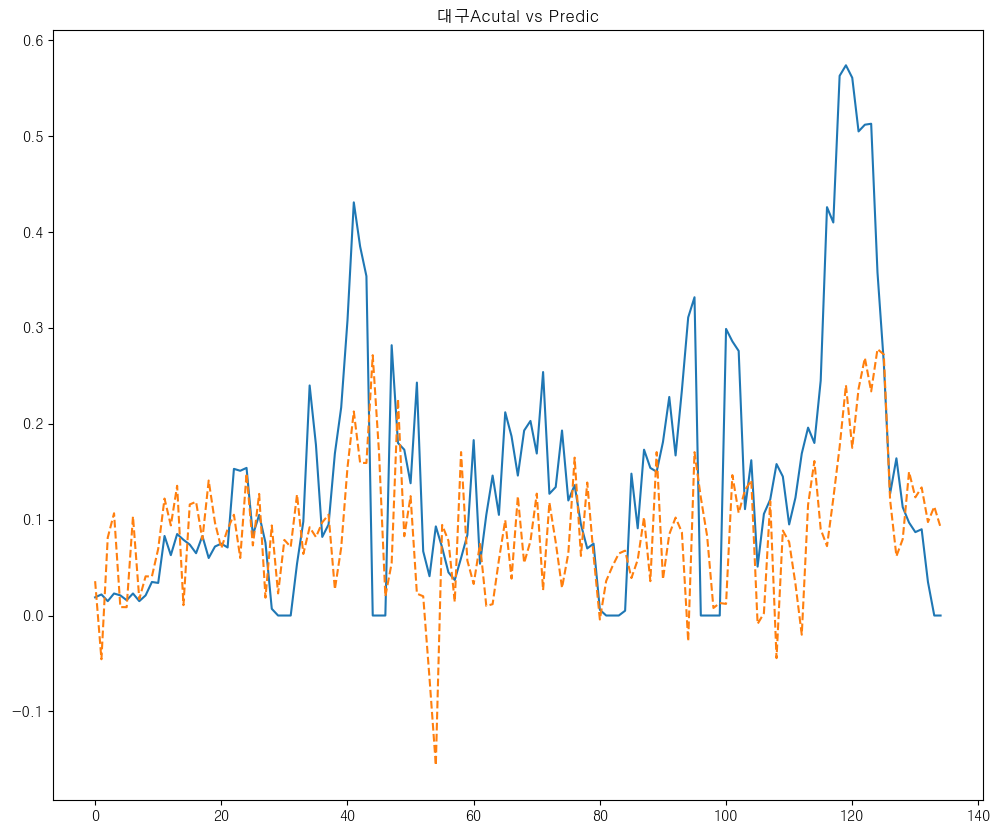

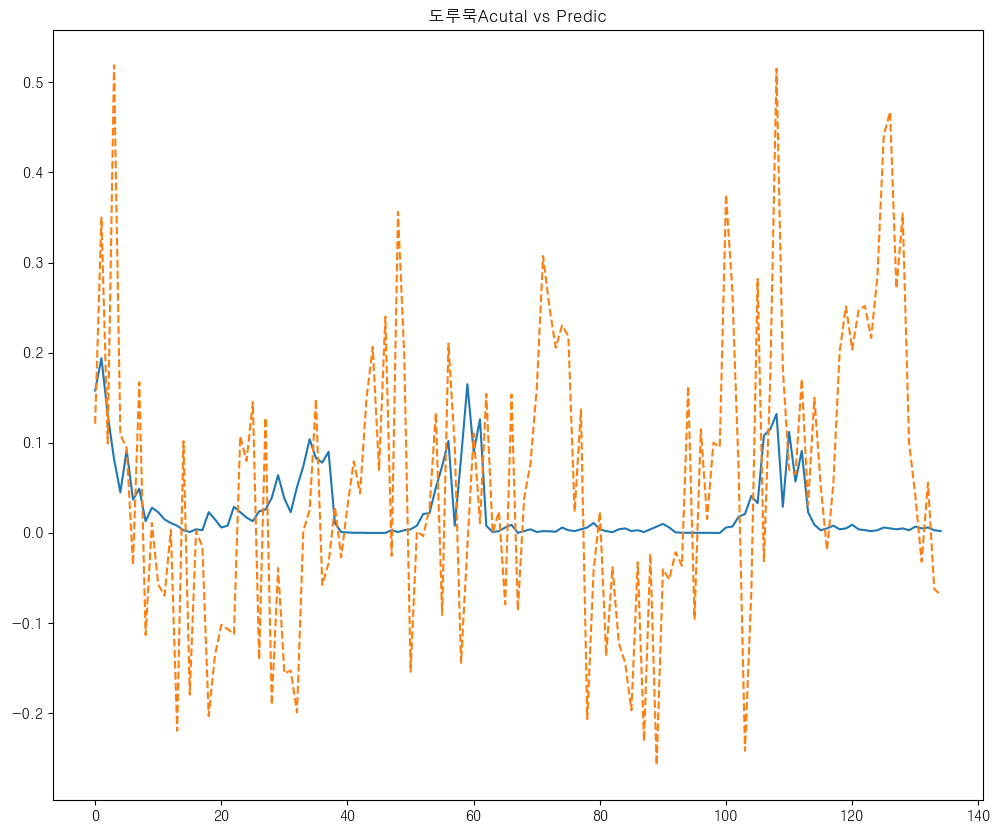

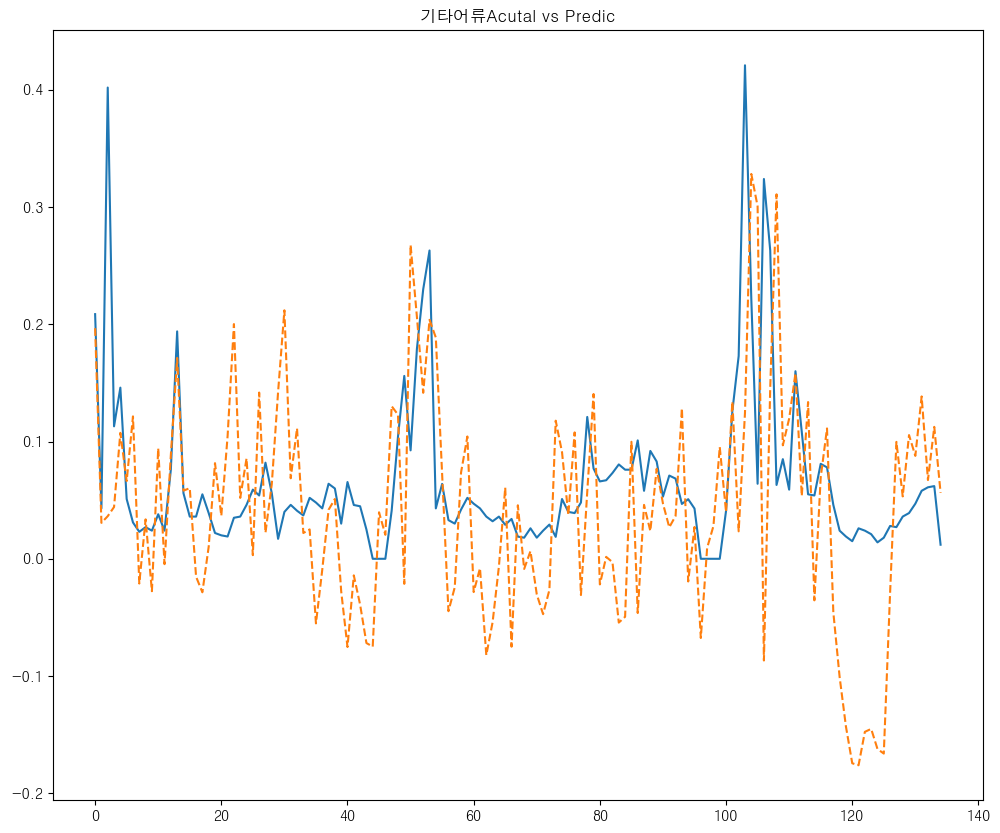

In [186]:
num_target = y_test_raw.shape[1]
target_name=['가자미류','청어','새우','대구','도루묵','기타어류']
for i in range(num_target):
    mse_target = mean_squared_error(y_test_raw[:,i], y_pred[:,i])
    mae_target = mean_absolute_error(y_test_raw[:,i], y_pred[:,i])
    target = target_name[i]
    print(f'{target}Mse:',mse_target,f'Mae:',mae_target)
    plt.figure(figsize=(12,10))
    plt.plot(y_test_raw[:,i],label='Actuarl')
    plt.plot(y_pred[:,i],label='Predicted',linestyle='--')
    plt.title(f'{target}Acutal vs Predic')


In [469]:
Rnn = Sequential()
Rnn.add(SimpleRNN(128, activation='tanh', input_shape=(train_x_cnn.shape[1],train_x_cnn.shape[2]),return_sequences=True))
Rnn.add(SimpleRNN(64, return_sequences=True,activation='tanh'))
Rnn.add(SimpleRNN(32,activation='tanh'))
Rnn.add(Dense(units=16, activation='relu'))
Rnn.add(Dense(y_train.shape[1],activation='softmax'))
Rnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [428]:
X_train.shape

In [358]:
print(Rnn.summary())

In [349]:
X_train.shape

In [470]:
Rnn_history = Rnn.fit(train_x_cnn,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

In [471]:
y_pred = Rnn.predict(test_x_cnn)
y_pred = np.argmax(y_pred,axis=1)
print('-----------RNN-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [179]:
X_train.shape[1]

In [183]:
help(LSTM)

In [472]:
Lstm = Sequential()
Lstm.add(LSTM(units=64, activation='tanh', return_sequences=True,input_shape=(train_x_cnn.shape[1],train_x_cnn.shape[2])))

Lstm.add(LSTM(units=32,activation='tanh',return_sequences=True))

Lstm.add(LSTM(units=16))

#출력층
Lstm.add(Dense(9, activation='softmax'))

In [ ]:
#print(X_train.shape)

In [473]:
Lstm.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
Lstm.summary()
Lstm_history = Lstm.fit(train_x_cnn,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

In [474]:
y_pred = Lstm.predict(test_x_cnn)
y_pred = np.argmax(y_pred,axis=1)
print('-----------LSTM-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [ ]:
eval_df = pd.DataFrame({'Model': ['FNN', 'CNN', 'RNN', 'LSTM'],
                        'Accuracy': [accuracy_score(y_test_raw, np.argmax(Fnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Cnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Rnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Lstm.predict(X_test),aixs=1))]})

In [210]:
X_train.shape[1]

In [467]:
## CNN 특징 추출
Cnn_F =Sequential()
Cnn_F.add(Conv1D(32,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn_F.add(Conv1D(64,2, activation='relu'))
Cnn_F.add(MaxPooling1D(2))


Cnn_F.summary()

In [468]:
train_x_cnn = Cnn_F.predict(X_train)
test_x_cnn = Cnn_F.predict(X_test)

train_x_cnn.shape

In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.model_selection import  GridSearchCV
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
ocean_data

TypeError: 'Index' object is not callable

In [99]:
col=['가자미류', '청어', '새우', '대구', '도루묵', '기타어류', '총어획량 ', '금지여부','염분_50m','염분_100m', '염분_200m', '염분_300m', '염분_400m', '염분_500m', '해저수온_100m','해저수온_200m', '해저수온_300m', '해저수온_400m', '해저수온_500m','mean_해수면높이','평균 풍속(m/s)', '평균기압(hPa)', '평균 상대습도(%)', '평균 기온(°C)', '평균 최대 파고(m)','평균 파주기(sec)']

In [104]:
data_col = ocean_data.iloc[:,:6].columns.tolist()

In [106]:
ocean_data

,가자미류,청어,새우,대구,도루묵,기타어류,총어획량,금지여부,염분_50m,염분_100m,...,해저수온_300m,해저수온_400m,해저수온_500m,mean_해수면높이,평균 풍속(m/s),평균기압(hPa),평균 상대습도(%),평균 기온(°C),평균 최대 파고(m),평균 파주기(sec)
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-05,0.627,0.076,0.068,0.041,0.032,0.156,37872.0,0,34.087777,34.056530,...,2.618654,1.170916,0.867136,0.071283,5.420000,1018.220000,60.000000,4.100000,2.360000,3.680000
2011-03-12,0.485,0.016,0.034,0.024,0.378,0.063,79934.0,0,34.115109,34.077639,...,2.705634,1.205661,0.873943,0.069657,6.785714,1017.542857,53.142857,6.257143,1.957143,2.828571
2011-03-19,0.698,0.070,0.050,0.025,0.056,0.101,64910.0,0,34.147962,34.108084,...,2.605231,1.209041,0.862841,0.065963,6.771429,1017.828571,68.000000,7.457143,2.442857,3.371429
2011-03-26,0.751,0.005,0.050,0.026,0.064,0.104,53873.0,0,34.173486,34.129434,...,2.346879,1.180908,0.810952,0.055197,6.600000,1019.700000,64.000000,6.042857,2.257143,2.971429
2011-04-02,0.800,0.000,0.049,0.050,0.008,0.093,86681.0,0,34.210325,34.145569,...,2.045112,1.085696,0.740865,0.050113,5.171429,1021.400000,64.000000,9.100000,1.357143,2.728571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-04,0.555,0.013,0.291,0.087,0.007,0.047,80427.0,0,33.642911,33.844457,...,1.013735,0.480097,0.290103,0.305960,9.400000,1020.485714,62.142857,7.742857,2.600000,5.028571
2025-01-11,0.550,0.025,0.272,0.090,0.005,0.058,57854.0,0,33.724002,33.837401,...,1.023831,0.502683,0.285548,0.290507,9.400000,1018.514286,59.000000,4.685714,4.000000,5.785714
2025-01-18,0.516,0.074,0.308,0.035,0.006,0.061,86373.0,0,33.768318,33.842817,...,1.058974,0.518791,0.281510,0.239657,9.400000,1021.900000,59.000000,7.042857,2.700000,4.914286


In [18]:
data_col = ocean_data.iloc[:,:7].columns.tolist()

In [117]:
select_col = select_col+['총어획량 ']


In [109]:
select_col = stepwise_selection(X, y, verbose=True)

Add 청어 with p-value 0.000000
Add 도루묵 with p-value 0.000000
Add 해저수온_100m with p-value 0.000000
Add 대구 with p-value 0.000000
Add 평균 최대 파고(m) with p-value 0.000000
Add 금지여부 with p-value 0.000021
Add 염분_50m with p-value 0.000010
Add 해저수온_200m with p-value 0.000034
Add mean_해수면높이 with p-value 0.004672
Add 평균기압(hPa) with p-value 0.024709
Add 새우 with p-value 0.029006

Final Selected Variables:
['청어', '도루묵', '해저수온_100m', '대구', '평균 최대 파고(m)', '금지여부', '염분_50m', '해저수온_200m', 'mean_해수면높이', '평균기압(hPa)', '새우']

Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  총어획량    R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     65.84
Date:                Wed, 07 May 2025   Prob (F-statistic):          6.77e-101
Time:                        16:06:24   Log-Likelihood:                -9103.7
N

In [119]:
ocean_data = ocean_data[select_col]

In [130]:
window_size = 12
X,y,time_list = create_sequence(ocean_data, window_size,'총어획량 ')

In [123]:
scaler= MinMaxScaler()
y_scaler= StandardScaler()

In [141]:
y_test.shape

(145, 8)

In [438]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reshape,y_train)
y_pred = dt.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

정확도: 0.24475524475524477
혼동행렬:
 [[ 6  3  0  0  0  0  0  1  0]
 [ 0  5  0  0  3  0  0  0  0]
 [ 0  2  0  0 18  0  1  6  0]
 [ 1 15  0  0  5  5 30  0  1]
 [ 0  0  0  0  1  0  0  4  0]
 [ 0  1  0  0  3 13  5  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 2  1  0  0  1  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0]]
분류보고서
               precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.19      0.62      0.29         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.03      0.20      0.06         5
           5       0.72      0.59      0.65        22
           6       0.00      0.00      0.00         0
           7       0.48      0.71      0.57        14
           8       0.00      0.00      0.00         0

    accuracy                           0.24       143
   macro avg       0.23      0.30      0.24       143
weighted avg       0.22      0.24      0

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [ ]:
model_xgb = XGBClassifier(random_state=42)
hyperparams_xgb = {'n_estimators': [100, 200, 300],
				 'learning_rate': [0.01, 0.05, 0.1],
				 'max_depth': [3, 5, 7]}    
model_rf = RandomForestClassifier(random_state=42)
hyperparams_rf = {'n_estimators': [10, 50, 100],
				'max_depth': [None, 10, 20],
				'min_samples_split': [2, 5, 10],
				'min_samples_leaf': [1, 2, 4],
				'bootstrap': [True, False],}

In [143]:
rf_df = pd.DataFrame({'time':time_list_test,'y_test':y_test_raw,'y_pred':y_pred})


NameError: name 'y_pred' is not defined

In [ ]:
model_info = GridSearchCV(estimator=model_rf,
                    param_grid = hyperparams_rf,
                    cv=5)
model_info.fit(X_train,y_train)
model_n = model_info.best_estimator_
y_pred = model_n.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

정확도: 0.38620689655172413
혼동행렬:
 [[11  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 25  2  0  0]
 [ 3 19  0  0  0  0 35  0]
 [ 0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0 20  2  0]
 [ 0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0 12]]
분류보고서
               precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.30      1.00      0.46         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.17      1.00      0.29         5
           5       0.91      0.91      0.91        22
           6       0.00      0.00      0.00         0
           7       1.00      0.80      0.89        15

    accuracy                           0.39       145
   macro avg       0.38      0.59      0.42       145
weighted avg       0.31      0.39      0.32       145



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten,Dropout,SimpleRNN,LSTM, MaxPooling1D,AveragePooling1D,GlobalAvgPool1D

In [136]:
y_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [126]:
Fnn = Sequential()
Fnn.add(Dense(128,activation='relu',input_dim=(X_train_reshape.shape[1])))
Fnn.add(Dense(64,activation='relu'))
Fnn.add(Dense(32,activation='relu'))
Fnn.add(Dense(y_train.shape[1],activation='softmax'))
Fnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
Fnn.summary()

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 128)            │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,465 (119.00 KB)

 Trainable params: 30,465 (119.00 KB)

 Non-trainable params: 0 (0.00 B)

In [441]:
y_pred = Fnn.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print('-----------FNN-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
-----------FNN-----------
정확도: 0.27972027972027974
혼동행렬:
 [[ 4  4  0  0  0  0  0  2]
 [ 1  7  0  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  1]
 [ 0 22  0  0  0  3 32  0]
 [ 0  0  0  0  1  0  0  4]
 [ 0  0  0  0  2 16  4  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0 12]]
분류보고서
               precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.21      0.88      0.34         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.03      0.20      0.06         5
           5       0.84      0.73      0.78        22
           6       0.00      0.00      0.00         0
           7       0.63      0.86      0.73        14

    accuracy                           0.28       143
   macro avg       0.31      0.38      0.30       143
weighted avg       0.26      0.28      0.25       143



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [64]:
Cnn = Sequential()
Cnn.add(Conv1D(64,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn.add(MaxPooling1D(2))
Cnn.add(Flatten())
Cnn.add(Dense(32,activation = 'relu'))
Cnn.add(Dense(16,activation = 'relu'))
Cnn.add(Dense(1))

In [175]:
# model=Sequential([
#             Conv1D(64,3, activation='relu', input_shape=(self.window_size,4)),
#             Conv1D(32,3,activation='relu'),
#             Flatten(),
#             Dense(50,activation='relu'),
#             Dense(1)
#         ])
#         model.compile(optimizer='adam',loss='mse')

In [138]:
cnn_y_test_inv .shape

(286, 1)

In [469]:
Rnn = Sequential()
Rnn.add(SimpleRNN(128, activation='tanh', input_shape=(train_x_cnn.shape[1],train_x_cnn.shape[2]),return_sequences=True))
Rnn.add(SimpleRNN(64, return_sequences=True,activation='tanh'))
Rnn.add(SimpleRNN(32,activation='tanh'))
Rnn.add(Dense(units=16, activation='relu'))
Rnn.add(Dense(y_train.shape[1],activation='softmax'))
Rnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [428]:
X_train.shape

(572, 12, 26)

In [349]:
X_train.shape

(540, 52, 47)

In [471]:
y_pred = Rnn.predict(test_x_cnn)
y_pred = np.argmax(y_pred,axis=1)
print('-----------RNN-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
-----------RNN-----------
정확도: 0.3006993006993007
혼동행렬:
 [[ 5  2  0  0  1  0  0  2]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 25  2  0  0]
 [ 0 27  0  0  0  8 22  0]
 [ 0  0  0  0  4  0  0  1]
 [ 0  0  0  0  0 19  3  0]
 [ 0  0  0  0  0  0  0  0]
 [ 1  0  0  0  6  0  0  7]]
분류보고서
               precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.22      1.00      0.36         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.11      0.80      0.20         5
           5       0.66      0.86      0.75        22
           6       0.00      0.00      0.00         0
           7       0.70      0.50      0.58        14

    accuracy                           0.30       143
   macro avg       0.31      0.46      0.31       143
weighted avg       0.24      0.30      0.24       143



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [183]:
help(LSTM)

Help on class LSTM in module keras.src.layers.rnn.lstm:

class LSTM(keras.src.layers.rnn.rnn.RNN)
 |  LSTM(units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, seed=None, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, use_cudnn='auto', **kwargs)
 |  
 |  Long Short-Term Memory layer - Hochreiter 1997.
 |  
 |  Based on available runtime hardware and constraints, this layer
 |  will choose different implementations (cuDNN-based or backend-native)
 |  to maximize the performance. If a GPU is available and all
 |  the arguments to the layer meet the requirement of the cuDNN kernel
 |  (see below

In [ ]:
#print(X_train.shape)

(578, 4, 47)


In [474]:
y_pred = Lstm.predict(test_x_cnn)
y_pred = np.argmax(y_pred,axis=1)
print('-----------LSTM-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
-----------LSTM-----------
정확도: 0.2937062937062937
혼동행렬:
 [[ 7  2  0  0  0  0  0  1]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 24  3  0  0]
 [ 0 23  0  0  4  3 27  0]
 [ 0  0  0  0  4  0  0  1]
 [ 0  0  0  0  0 18  4  0]
 [ 0  0  0  0  0  0  0  0]
 [ 3  0  0  0  6  0  0  5]]
분류보고서
               precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.24      1.00      0.39         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.11      0.80      0.19         5
           5       0.75      0.82      0.78        22
           6       0.00      0.00      0.00         0
           7       0.71      0.36      0.48        14

    accuracy                           0.29       143
   macro avg       0.31      0.46      0.32       143
weighted avg       0.25      0.29      0.24       143



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [ ]:
eval_df = pd.DataFrame({'Model': ['FNN', 'CNN', 'RNN', 'LSTM'],
                        'Accuracy': [accuracy_score(y_test_raw, np.argmax(Fnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Cnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Rnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Lstm.predict(X_test),aixs=1))]})

In [210]:
X_train.shape[1]

4

In [166]:
## CNN 특징 추출
Cnn_F =Sequential()
Cnn_F.add(Conv1D(32,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn_F.add(Conv1D(64,2, activation='relu'))
Cnn_F.add(MaxPooling1D(2))
Cnn_F.add(Conv1D(128,2, activation='relu'))
Cnn_F.add(MaxPooling1D(2))
Cnn_F.add(Conv1D(256,2, activation='relu'))
Cnn_F.add(MaxPooling1D(2))


Cnn_F.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 55, 32)         │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 54, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 26, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 12, 256)        │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 6, 256)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,880 (339.38 KB)

 Trainable params: 86,880 (339.38 KB)

 Non-trainable params: 0 (0.00 B)

In [167]:
train_x_cnn = Cnn_F.predict(X_train)
test_x_cnn = Cnn_F.predict(X_test)

train_x_cnn.shape

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


(536, 6, 256)